**General Approach:**

*Our Model will treat CNN as image Model and RNN/LSTM as language model. We are goig to get vectors from both layers which are given to Dense layer to make final predcition.*

*Encoding for Images : We will use Inception V3 model*  

*Encoding our Text: We will use pre trained Glove Model.* 

*To generate the captions we will use Greedy Search or Beam Search. Depending on the image this is used to pick the best words.*


**DataSet**

*We are going to use Filckr 8K Dataset: We are haivng 8000 images with each image has 5 captions*


**Import the required libraries**

In [ ]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical

**Connecting to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# check what files exists
!ls

drive  sample_data


In [ ]:
# check present working directory.
!pwd

/content


**Data loading and Preprocessing**

In [ ]:

token_path = "/content/drive/MyDrive/Flick8k/Flickr8k_Text/Flickr8k.token.txt"
train_images_path = '/content/drive/MyDrive/Flick8k/Flickr8k_Text/Flickr_8k.trainImages.txt'
test_images_path = '/content/drive/MyDrive/Flick8k/Flickr8k_Text/Flickr_8k.testImages.txt'
images_path = '/content/drive/MyDrive/Flick8k/Flicker8k_Dataset/'
glove_path = '/content/drive/MyDrive/glove.6B.200d.txt'

doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In the Flickr8k dataset, each image is associated with five different captions that describe the entities and events depicted in the image that were collected.

Next, we create a dictionary named “descriptions” which contains the name of the image as keys and a list of the 5 captions for the corresponding image as values.

In [ ]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

In [ ]:
for k,v in descriptions.items():
  print(k,'---',v)
  break

1000268201_693b08cb0e --- ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


**Basic text clean to get rid of punctuation and convert our descriptions to lowercase**

In [ ]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

In [ ]:
# We have preprossed the data by converting the data into lower case and removing the unnecessary puntuations..
for k,v in descriptions.items():
  print(k,'---',v)
  break

1000268201_693b08cb0e --- ['a child in a pink dress is climbing up a set of stairs in an entry way ', 'a girl going into a wooden building ', 'a little girl climbing into a wooden playhouse ', 'a little girl climbing the stairs to her playhouse ', 'a little girl in a pink dress going into a wooden cabin ']


**Let’s visualize an example image and its captions:-**

In [ ]:
images_path

'/content/drive/MyDrive/Flick8k/Flicker8k_Dataset/'

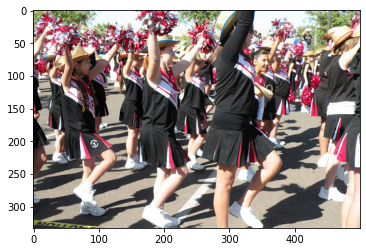

['a bunch of girls in cheerleader outfits ',
 'a large group of cheerleaders walking in a parade',
 'cheerleaders perform ',
 'many cheerleaders wearing black  walk down the street ',
 'parade of cheerleaders wearing black  pink and white uniforms ']

In [ ]:
pic = '/3423802527_94bd2b23b0.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['3423802527_94bd2b23b0']

 **Get all the unique word from  8000*5 (i.e. 40000) image captions in the dataset.**

In [ ]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8828


In [ ]:
vocabulary

{'headbands',
 'storefronts',
 'fourth',
 'reviewing',
 'gal',
 'next',
 'straddle',
 'wuth',
 'ejected',
 'concentrates',
 'mime',
 'positions',
 'soaks',
 'glacier',
 'rink',
 'clustered',
 'cylindrical',
 'shots',
 'pounces',
 'beret',
 'offensive',
 'ambulance',
 'cheerfully',
 'gaze',
 'strike',
 'extended',
 'hollywood',
 'craft',
 'mother',
 'brindle',
 'tune',
 'poor',
 'confronted',
 'longlegged',
 'rectangular',
 'clouds',
 'chairs',
 'continue',
 'itself',
 'bouncy',
 'juggling',
 'pail',
 'bandaged',
 'computer',
 'rifle',
 'arches',
 'diner',
 'arms',
 'necked',
 'whie',
 'noisemaker',
 'pyranha',
 'frown',
 'winner',
 'gowns',
 'steve',
 'somersaulting',
 'moutnain',
 'kit',
 'asphalt',
 'measuring',
 'entertainers',
 'buttondown',
 'rainbow',
 'performed',
 'our',
 'arcade',
 'sledding',
 'depth',
 'frightened',
 'multipiercings',
 'stocking',
 'marked',
 'backwards',
 'clean',
 'cradling',
 'wildebeest',
 'varied',
 'muscular',
 'scratch',
 'mingle',
 'pomeranian',
 'po

Club image id’s and their new cleaned captions in the same format as the token.txt file:-

In [ ]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [ ]:
new_descriptions

'1000268201_693b08cb0e a child in a pink dress is climbing up a set of stairs in an entry way \n1000268201_693b08cb0e a girl going into a wooden building \n1000268201_693b08cb0e a little girl climbing into a wooden playhouse \n1000268201_693b08cb0e a little girl climbing the stairs to her playhouse \n1000268201_693b08cb0e a little girl in a pink dress going into a wooden cabin \n1001773457_577c3a7d70 a black dog and a spotted dog are fighting\n1001773457_577c3a7d70 a black dog and a tricolored dog playing with each other on the road \n1001773457_577c3a7d70 a black dog and a white dog with brown spots are staring at each other in the street \n1001773457_577c3a7d70 two dogs of different breeds looking at each other on the road \n1001773457_577c3a7d70 two dogs on pavement moving toward each other \n1002674143_1b742ab4b8 a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl \n1002674143_1b742ab4b8 a little girl is sitting in front of a large painted rai

**Next, we load all the 6000 training image id’s in a variable train from the ‘Flickr_8k.trainImages.txt’ file:-**

In [ ]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

In [ ]:
len(train)

6000

In [ ]:
train

{'3380407617_07b53cbcce',
 '2266061169_dfbf8f0595',
 '300222673_573fd4044b',
 '3724487641_d2096f10e5',
 '2244551043_21b8cca866',
 '3225037367_a71fa86319',
 '3294202771_e8ee78a439',
 '837919879_94e3dacd83',
 '3264937930_9623496b64',
 '2416964653_db3c2b6a0e',
 '3339558806_b4afdc8394',
 '3544573946_e03aebbfde',
 '2716457668_187a6d2b1c',
 '2447289477_e888df561d',
 '2084103826_ffd76b1e3e',
 '2882743431_c3e6cd1b5c',
 '3122773470_b622205948',
 '2848266893_9693c66275',
 '2892467862_52a3c67418',
 '2887614578_ed7ba21775',
 '3216901052_269ace7b3c',
 '2246717855_c0c08fe5d2',
 '3319058642_885d756295',
 '3532761259_14026c1e96',
 '3232030272_b2480a5fe7',
 '1236964638_1808784a3c',
 '241345942_ea76966542',
 '2254913901_569f568926',
 '2704362232_7d84503433',
 '3463922449_f6040a2931',
 '1361420539_e9599c60ae',
 '2709275718_73fcf08c23',
 '2119660490_ce0d4d1f73',
 '2272489996_95b0a62d15',
 '3048211972_db71d104c2',
 '303795791_98ebc1d19a',
 '3476381830_3751dd9339',
 '3157622277_9f59b4f62f',
 '762947607_2001

**Now we save all the training and testing images in train_img and test_img lists respectively:-**

In [ ]:
images_path

'/content/drive/MyDrive/Flick8k/Flicker8k_Dataset/'

In [ ]:
print(train_images_path)
print(test_images_path)

/content/drive/MyDrive/Flick8k/Flickr8k_Text/Flickr_8k.trainImages.txt
/content/drive/MyDrive/Flick8k/Flickr8k_Text/Flickr_8k.testImages.txt


In [ ]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)
print(train_img)
print(test_img)

['/content/drive/MyDrive/Flick8k/Flicker8k_Dataset/532914728_c5d8d56b0b.jpg', '/content/drive/MyDrive/Flick8k/Flicker8k_Dataset/3674565156_14d3b41450.jpg', '/content/drive/MyDrive/Flick8k/Flicker8k_Dataset/3207654194_43d6bebd68.jpg', '/content/drive/MyDrive/Flick8k/Flicker8k_Dataset/2466495935_623b144183.jpg', '/content/drive/MyDrive/Flick8k/Flicker8k_Dataset/2507182524_7e83c6de82.jpg', '/content/drive/MyDrive/Flick8k/Flicker8k_Dataset/2294688426_96c8614f1d.jpg', '/content/drive/MyDrive/Flick8k/Flicker8k_Dataset/2656039837_f46b29af92.jpg', '/content/drive/MyDrive/Flick8k/Flicker8k_Dataset/3050264832_4215f2b398.jpg', '/content/drive/MyDrive/Flick8k/Flicker8k_Dataset/1053804096_ad278b25f1.jpg', '/content/drive/MyDrive/Flick8k/Flicker8k_Dataset/608257195_6ec6f48e37.jpg', '/content/drive/MyDrive/Flick8k/Flicker8k_Dataset/1119463452_69d4eecd08.jpg', '/content/drive/MyDrive/Flick8k/Flicker8k_Dataset/1469358746_2a879abaf3.jpg', '/content/drive/MyDrive/Flick8k/Flicker8k_Dataset/3331900249_5872

**We load the descriptions of the training images into a dictionary. However, we will add two tokens in every caption, which are ‘startseq’ and ‘endseq’**

In [ ]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

In [ ]:
train_descriptions


{'1000268201_693b08cb0e': ['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
  'startseq a girl going into a wooden building endseq',
  'startseq a little girl climbing into a wooden playhouse endseq',
  'startseq a little girl climbing the stairs to her playhouse endseq',
  'startseq a little girl in a pink dress going into a wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq a black dog and a spotted dog are fighting endseq',
  'startseq a black dog and a tricolored dog playing with each other on the road endseq',
  'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl endseq',
  'startseq a little girl is sitti

**Create a list of all the training captions:**

In [ ]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)



In [ ]:
print(all_train_captions)

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq', 'startseq a girl going into a wooden building endseq', 'startseq a little girl climbing into a wooden playhouse endseq', 'startseq a little girl climbing the stairs to her playhouse endseq', 'startseq a little girl in a pink dress going into a wooden cabin endseq', 'startseq a black dog and a spotted dog are fighting endseq', 'startseq a black dog and a tricolored dog playing with each other on the road endseq', 'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq', 'startseq a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl endseq', 'startseq a little girl is sitting in front of a large painted rainbow endseq', 'startseq a small girl in the grass plays with finge

In [ ]:
print(len(all_train_captions))

30000


**To make our model more robust we will reduce our vocabulary to only those words which occur at least 10 times in the entire corpus.**

In [ ]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


In [ ]:
word_counts

{'startseq': 30000,
 'a': 46781,
 'child': 1120,
 'in': 14085,
 'pink': 543,
 'dress': 260,
 'is': 6907,
 'climbing': 375,
 'up': 903,
 'set': 81,
 'of': 4967,
 'stairs': 81,
 'an': 1807,
 'entry': 1,
 'way': 41,
 'endseq': 30000,
 'girl': 2414,
 'going': 111,
 'into': 757,
 'wooden': 209,
 'building': 373,
 'little': 1266,
 'playhouse': 6,
 'the': 13509,
 'to': 2303,
 'her': 861,
 'cabin': 3,
 'black': 2854,
 'dog': 6159,
 'and': 6672,
 'spotted': 27,
 'are': 2619,
 'fighting': 97,
 'tricolored': 10,
 'playing': 1486,
 'with': 5763,
 'each': 318,
 'other': 567,
 'on': 8006,
 'road': 305,
 'white': 2921,
 'brown': 1995,
 'spots': 22,
 'staring': 43,
 'at': 2101,
 'street': 703,
 'two': 4246,
 'dogs': 1620,
 'different': 28,
 'breeds': 5,
 'looking': 563,
 'pavement': 39,
 'moving': 27,
 'toward': 109,
 'covered': 229,
 'paint': 44,
 'sits': 437,
 'front': 996,
 'painted': 50,
 'rainbow': 18,
 'hands': 180,
 'bowl': 21,
 'sitting': 1018,
 'large': 894,
 'small': 940,
 'grass': 1222,
 'p

In [ ]:
word_counts.values()

dict_values([30000, 46781, 1120, 14085, 543, 260, 6907, 375, 903, 81, 4967, 81, 1807, 1, 41, 30000, 2414, 111, 757, 209, 373, 1266, 6, 13509, 2303, 861, 3, 2854, 6159, 6672, 27, 2619, 97, 10, 1486, 5763, 318, 567, 8006, 305, 2921, 1995, 22, 43, 2101, 703, 4246, 1620, 28, 5, 563, 39, 27, 109, 229, 44, 437, 996, 50, 18, 180, 21, 1018, 894, 940, 1222, 392, 2, 4, 291, 229, 14, 32, 1976, 601, 5374, 43, 295, 1443, 1711, 903, 300, 38, 17, 12, 44, 535, 74, 28, 378, 140, 972, 106, 274, 556, 493, 7, 252, 86, 137, 1, 2271, 1, 40, 33, 1, 5, 56, 186, 45, 1976, 1, 144, 104, 2, 155, 32, 130, 1589, 356, 48, 134, 270, 1533, 9, 25, 6, 924, 724, 752, 26, 698, 264, 113, 1335, 132, 743, 64, 654, 47, 526, 2024, 1302, 15, 872, 223, 2634, 138, 2, 439, 229, 25, 19, 103, 1, 870, 37, 88, 117, 491, 357, 1363, 1667, 174, 569, 146, 1062, 42, 183, 100, 52, 322, 2, 136, 1103, 26, 18, 1173, 995, 48, 4, 51, 133, 58, 119, 713, 4, 1119, 5, 373, 195, 3, 706, 3, 2, 157, 909, 2093, 1, 26, 25, 7, 373, 124, 238, 25, 204, 322,

In [ ]:
# import pandas as pd
# #data = {'counts': word_counts.values()}
# # Calling DataFrame constructor on list 
# df = pd.DataFrame(word_counts.) 
# df 
# df['counts'].plt(gird=True,figsize=(20,6))

We create two dictionaries to map words to an index and vice versa. Also, we append 1 to our vocabulary since we append 0’s to make all captions of equal length

In [ ]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [ ]:
vocab_size

1660

In [ ]:
print(ixtoword)
print(wordtoix)

{1: 'startseq', 2: 'a', 3: 'child', 4: 'in', 5: 'pink', 6: 'dress', 7: 'is', 8: 'climbing', 9: 'up', 10: 'set', 11: 'of', 12: 'stairs', 13: 'an', 14: 'way', 15: 'endseq', 16: 'girl', 17: 'going', 18: 'into', 19: 'wooden', 20: 'building', 21: 'little', 22: 'the', 23: 'to', 24: 'her', 25: 'black', 26: 'dog', 27: 'and', 28: 'spotted', 29: 'are', 30: 'fighting', 31: 'tricolored', 32: 'playing', 33: 'with', 34: 'each', 35: 'other', 36: 'on', 37: 'road', 38: 'white', 39: 'brown', 40: 'spots', 41: 'staring', 42: 'at', 43: 'street', 44: 'two', 45: 'dogs', 46: 'different', 47: 'looking', 48: 'pavement', 49: 'moving', 50: 'toward', 51: 'covered', 52: 'paint', 53: 'sits', 54: 'front', 55: 'painted', 56: 'rainbow', 57: 'hands', 58: 'bowl', 59: 'sitting', 60: 'large', 61: 'small', 62: 'grass', 63: 'plays', 64: 'it', 65: 'there', 66: 'pigtails', 67: 'painting', 68: 'young', 69: 'outside', 70: 'man', 71: 'lays', 72: 'bench', 73: 'while', 74: 'his', 75: 'by', 76: 'him', 77: 'which', 78: 'also', 79: 't

In [ ]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


**Glove Embeddings**


Word Vectors maps word to vector space with the similar words are clsutered together.....


In [ ]:
embeddings_index = {} 
f = open(glove_path, encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [ ]:
len(embeddings_index['question'])

200

As out Total vocabulary size is 1660

**We make the matrix of shape (1660,200) consisting of our vocabulary and the 200-d vector**

In [ ]:
vocab_size

1660

In [ ]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
print((vocab_size),len(embedding_matrix))

1660 1660


In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.24168999, -0.34534001, -0.22307   , ...,  0.27801001,
        -0.10171   , -0.071521  ],
       ...,
       [-0.021736  ,  0.15308   ,  0.11436   , ...,  0.078342  ,
        -0.39166999,  0.12937   ],
       [ 0.20298   , -0.10048   , -0.33627   , ...,  0.40496999,
        -0.19888   , -0.10866   ],
       [ 0.41156   , -0.25863001,  0.016209  , ..., -0.25419   ,
        -0.27496001,  0.67840999]])

**Visualize the embeddings**
To visualize the embeddings, upload them to the embedding projector.

Open the Embedding Projector (this can also run in a local TensorBoard instance).

Click on "Load data".

Upload the two files you created above: vecs.tsv and meta.tsv.

The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful".

In [ ]:
import io
out_v = io.open('/content/drive/MyDrive/vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('/content/drive/MyDrive/metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if  index == 0: continue # skip 0, it's padding.
  vec = embedding_matrix[index] 
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

**Analysis**


**The TensorBoard Projector is a great tool for analyzing your data and seeing embedding values relative to each other. The dashboard allows searching for specific terms, and highlights words that are nearby in the embedding space. From this example we can see that what are the words which are closely related to play...**

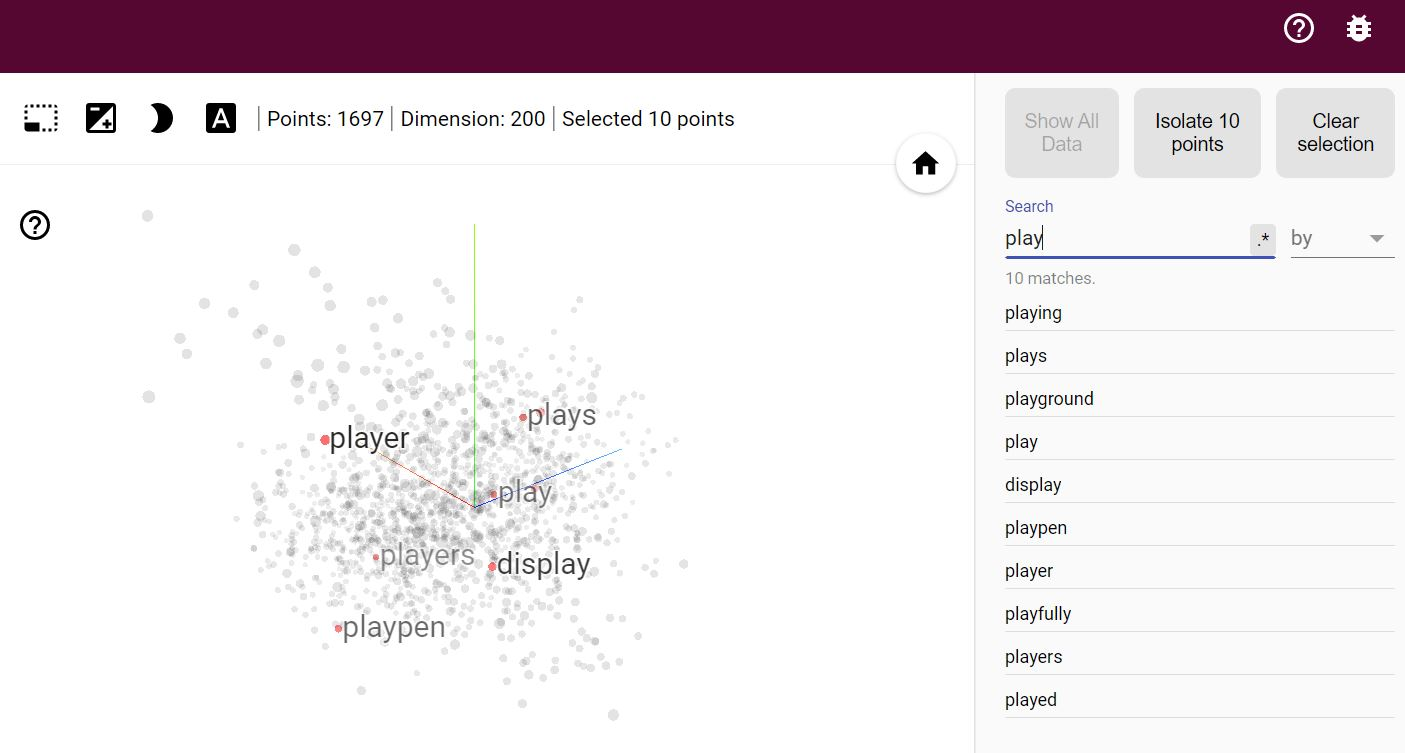

Further, We can also see which words are close to happy..
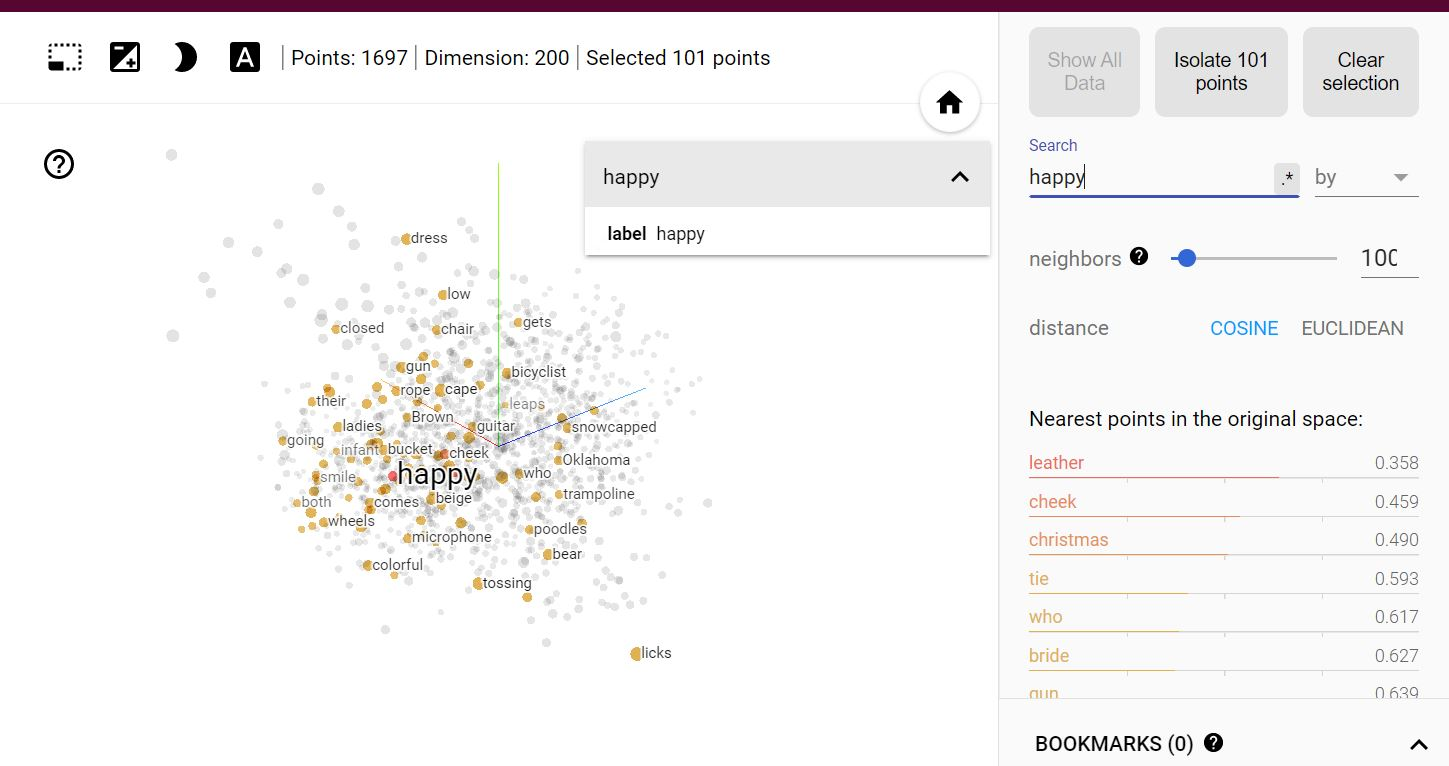

How, Many words are related to surface
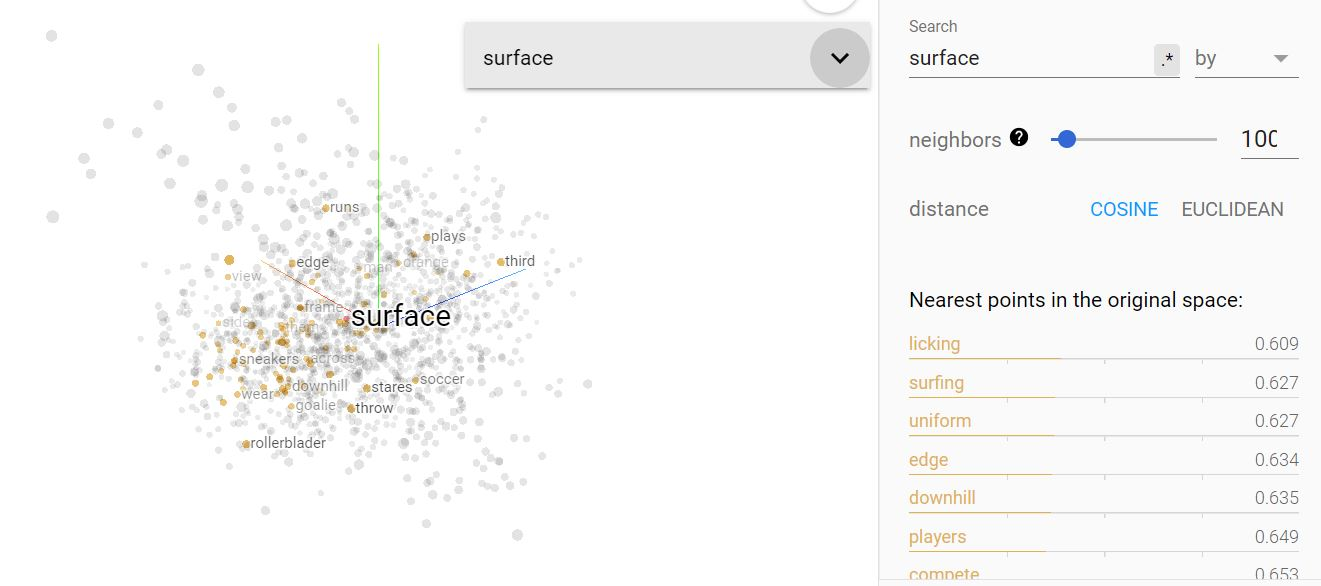

Step 4:- Model Building and Training

We are using InceptionV3 with weights of Imagenet...

**Step 4:- Model Building and Training**

Transfer learning using InceptionV3 network which is pre-trained on the ImageNet dataset.

In [ ]:
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
# Lets look how our Inception V3 model works...
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

We do not need to classify the images here, we only need to extract an image vector for our images. Hence we remove the softmax layer from the inceptionV3 model

In [ ]:
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
# Model after removing Softmax
model_new.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

**InceptionV3 we need to pre-process our input before feeding it into the model. Hence we define a preprocess function to reshape the images to (299 x 299) and feed to the preprocess_input() function of Keras**

In [ ]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

**we can go ahead and encode our training and testing images, i.e extract the images vectors of shape (2048,)**

In [ ]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [ ]:
import pickle

In [ ]:
len(train_img)

6000

In [ ]:
# encoding_train = {}
# for img in train_img:
#     encoding_train[img[len(images_path):]] = encode(img)
# train_features = encoding_train



In [ ]:
# a_file = open("/content/drive/MyDrive/data.pkl", "wb")
# pickle.dump(encoding_train, a_file)
# a_file.close()

In [ ]:
#len(train_features)
train_features

{'532914728_c5d8d56b0b.jpg': array([0.36056373, 0.14293775, 0.0444793 , ..., 0.49583673, 0.56449807,
        0.04936886], dtype=float32),
 '3674565156_14d3b41450.jpg': array([1.1091113 , 0.30450648, 0.6251131 , ..., 0.9069233 , 1.0023329 ,
        0.42386317], dtype=float32),
 '3207654194_43d6bebd68.jpg': array([0.33517104, 0.08305779, 0.03776689, ..., 0.39735204, 0.18577693,
        0.78118324], dtype=float32),
 '2466495935_623b144183.jpg': array([0.20657851, 0.25181213, 0.09494465, ..., 0.10538922, 0.40828568,
        0.24878332], dtype=float32),
 '2507182524_7e83c6de82.jpg': array([0.41920227, 0.08542079, 0.24351947, ..., 0.3042962 , 0.68406755,
        0.11944824], dtype=float32),
 '2294688426_96c8614f1d.jpg': array([0.51402175, 0.09810393, 0.5324199 , ..., 0.44207382, 0.17480056,
        0.45585856], dtype=float32),
 '2656039837_f46b29af92.jpg': array([0.10046898, 0.62889135, 0.367791  , ..., 0.08267988, 1.2101842 ,
        0.47557947], dtype=float32),
 '3050264832_4215f2b398.jpg'

In [ ]:
# We are creating Image Vector of  (2048,)
# print(train_features['241347271_a39a5a0070.jpg'])
# print(len(train_features['241347271_a39a5a0070.jpg']))

In [ ]:
# dictionary_data = {"a": 1, "b": 2}

# a_file = open("data.pkl", "wb")
# pickle.dump(dictionary_data, a_file)
# a_file.close()

#print(len(train_feature))

NameError: ignored

In [ ]:
a_file = open("/content/drive/MyDrive/data.pkl", "rb")
train_features = pickle.load(a_file)
print(len(train_feature))
print(train_features)

NameError: ignored

In [ ]:
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)
    

In [ ]:
encoding_test

{'2447284966_d6bbdb4b6e.jpg': array([0.26762182, 0.46901077, 0.1227883 , ..., 0.33993185, 0.76369864,
        0.3511253 ], dtype=float32),
 '1282392036_5a0328eb86.jpg': array([0.58822846, 0.36566153, 0.7528703 , ..., 0.2772632 , 0.5940893 ,
        0.1142105 ], dtype=float32),
 '2208310655_a3d83080c5.jpg': array([1.2925223 , 0.17721376, 0.79398036, ..., 0.91336447, 0.91372   ,
        0.3445285 ], dtype=float32),
 '2944362789_aebbc22db4.jpg': array([0.04577853, 0.35127538, 0.0726629 , ..., 0.7576405 , 0.14044258,
        0.04603515], dtype=float32),
 '3197917064_e679a44b8e.jpg': array([0.13005057, 0.17242403, 0.18545441, ..., 0.04812346, 0.97433066,
        0.26516843], dtype=float32),
 '2759860913_f75b39d783.jpg': array([0.27436632, 0.04070481, 0.6435108 , ..., 0.90905744, 0.7332847 ,
        1.3227012 ], dtype=float32),
 '3201427741_3033f5b625.jpg': array([0.18712518, 0.23715934, 0.03240408, ..., 0.0513676 , 0.08986804,
        0.17402253], dtype=float32),
 '1456393634_74022d9056.jpg

In [ ]:
print(vocab_size,embedding_dim)

1660 200


In [ ]:
train_descriptions['2255342813_5b2ac6d633']

['startseq a person climbing down a rocky cliffside with water below endseq',
 'startseq a person repelling on the side of a cliff face endseq',
 'startseq a person wearing black with a white helmet is going down a mountainside with water below endseq',
 'startseq extreme climbing over ocean endseq',
 'startseq looking down on someone climbing a cliff over water endseq']

In [ ]:
wordtoix

{'startseq': 1,
 'a': 2,
 'child': 3,
 'in': 4,
 'pink': 5,
 'dress': 6,
 'is': 7,
 'climbing': 8,
 'up': 9,
 'set': 10,
 'of': 11,
 'stairs': 12,
 'an': 13,
 'way': 14,
 'endseq': 15,
 'girl': 16,
 'going': 17,
 'into': 18,
 'wooden': 19,
 'building': 20,
 'little': 21,
 'the': 22,
 'to': 23,
 'her': 24,
 'black': 25,
 'dog': 26,
 'and': 27,
 'spotted': 28,
 'are': 29,
 'fighting': 30,
 'tricolored': 31,
 'playing': 32,
 'with': 33,
 'each': 34,
 'other': 35,
 'on': 36,
 'road': 37,
 'white': 38,
 'brown': 39,
 'spots': 40,
 'staring': 41,
 'at': 42,
 'street': 43,
 'two': 44,
 'dogs': 45,
 'different': 46,
 'looking': 47,
 'pavement': 48,
 'moving': 49,
 'toward': 50,
 'covered': 51,
 'paint': 52,
 'sits': 53,
 'front': 54,
 'painted': 55,
 'rainbow': 56,
 'hands': 57,
 'bowl': 58,
 'sitting': 59,
 'large': 60,
 'small': 61,
 'grass': 62,
 'plays': 63,
 'it': 64,
 'there': 65,
 'pigtails': 66,
 'painting': 67,
 'young': 68,
 'outside': 69,
 'man': 70,
 'lays': 71,
 'bench': 72,
 'whi

**Define our Model**

In [ ]:

 # We are having 2048 as Image Vector
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Processing the sequence from the text we are giving  embedding_dim as input
inputs2 = Input(shape=(max_length,))
# Here the vocab_size= 1660  and embedding_dim=200
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Constructing our decoder.....
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# Lets look how out model looks like......
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 200)      332000      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
_______________________________________________________________________________________

Input_2 is the image vector extracted by our InceptionV3 network. It is followed by a dropout of 0.5 to avoid overfitting and then fed into a Fully Connected layer.

Input_3 is the partial caption of max length 34 which is fed into the embedding layer. This is where the words are mapped to the 200-d Glove embedding. It is followed by a dropout of 0.5 to avoid overfitting. This is then fed into the LSTM for processing the sequence.



Both the Image model and the Language model are then concatenated by adding and fed into another Fully Connected layer. The layer is a softmax layer that provides probabilities to our 1660 word vocabulary.

Step 5:- Model Training

In [ ]:
# This is our Embedding layer
model.layers[2]

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    #print(photos)
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
epochs = 100
batch_size = 3
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)


In [ ]:
generator

<generator object data_generator at 0x7f405b5029e8>

In [ ]:
len(train_features)

6000

In [ ]:
len(train_descriptions)

6000

In [ ]:
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/100
200/200 [==============================] - 33s 164ms/step - loss: 4.3926 - accuracy: 0.2401
Epoch 2/100
200/200 [==============================] - 33s 164ms/step - loss: 3.4407 - accuracy: 0.3230
Epoch 3/100
200/200 [==============================] - 33s 164ms/step - loss: 3.1456 - accuracy: 0.3491
Epoch 4/100
200/200 [==============================] - 33s 164ms/step - loss: 2.9779 - accuracy: 0.3661
Epoch 5/100
200/200 [==============================] - 33s 164ms/step - loss: 2.8653 - accuracy: 0.3770
Epoch 6/100
200/200 [==============================] - 33s 163ms/step - loss: 2.7782 - accuracy: 0.3864
Epoch 7/100
200/200 [==============================] - 33s 164ms/step - loss: 2.7091 - accuracy: 0.3931
Epoch 8/100
200/200 [==============================] - 33s 165ms/step - loss: 2.6509 - accuracy: 0.3998
Epoch 9/100
200/200 [==============================] - 33s 163ms/step - loss: 2.6026 - accuracy: 0.4045
Epoch 10/100
200/200 [==============================] - 33s 164m

In [ ]:
model.history.history['accuracy']

[0.240102618932724,
 0.3229990303516388,
 0.3491121828556061,
 0.3661439120769501,
 0.3770192265510559,
 0.3863687217235565,
 0.3931407630443573,
 0.39975669980049133,
 0.40448445081710815,
 0.4099869132041931,
 0.41436415910720825,
 0.41856464743614197,
 0.4228653013706207,
 0.4253632128238678,
 0.42843255400657654,
 0.4322029948234558,
 0.4349159300327301,
 0.43756407499313354,
 0.4392696022987366,
 0.441743940114975,
 0.4433728754520416,
 0.44646286964416504,
 0.4476352334022522,
 0.44928479194641113,
 0.4516030251979828,
 0.45324963331222534,
 0.4547136127948761,
 0.4561157524585724,
 0.45779770612716675,
 0.4596122205257416,
 0.461170494556427,
 0.462923139333725,
 0.46472883224487305,
 0.4648996591567993,
 0.4670323133468628,
 0.46765974164009094,
 0.4701105058193207,
 0.4712357521057129,
 0.47222548723220825,
 0.47421085834503174,
 0.47457611560821533,
 0.4754892587661743,
 0.4758191704750061,
 0.47799602150917053,
 0.4790181517601013,
 0.48010215163230896,
 0.4798782765865326,


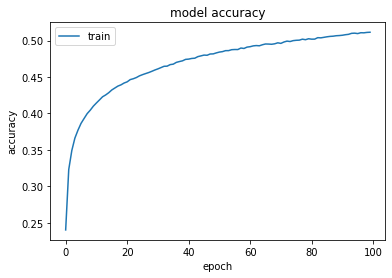

In [ ]:
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
#plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

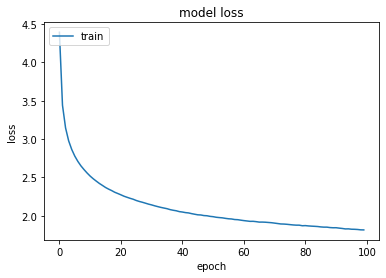

In [ ]:
# summarize history for loss
plt.plot(model.history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# probability distribution across all the words in the vocabulary we greedily pick the word with 
# the highest probability to get the next word prediction. This method is called Greedy Search.

def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        #print(yhat)
        yhat = np.argmax(yhat)
        #print(yhat)
        word = ixtoword[yhat]
        print(word)
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

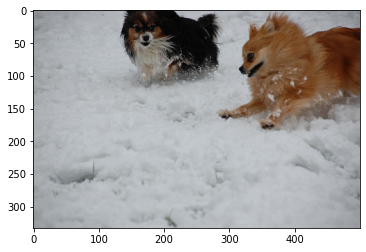

a
dog
is
running
through
the
snow
endseq
Greedy Search: a dog is running through the snow


In [ ]:
pic = '2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))

In [ ]:
# Another popular heuristic is the beam search that expands upon the greedy search and returns a list of most likely output sequences.

# Instead of greedily choosing the most likely next step as the sequence is constructed, the beam search expands all possible 
# next steps and keeps the k most likely, where k is a user-specified parameter 
# and controls the number of beams or parallel searches through the sequence of probabilities.


def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

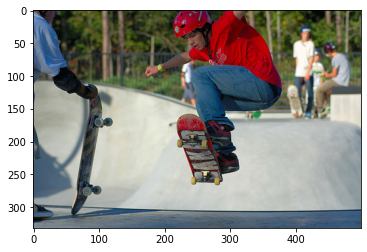

a
child
in
a
red
outfit
is
climbing
a
rock
wall
endseq
Greedy Search: a child in a red outfit is climbing a rock wall
Beam Search, K = 3: a young boy wearing a helmet is holding a foam cup in front of a white fence
Beam Search, K = 5: a little boy in a red jacket is climbing on a red railing
Beam Search, K = 7: a little boy in a blue jacket is climbing on a red playground


In [ ]:
pic = '2207244634_1db1a1890b.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))
greedy=greedySearch(image).split()
reference=descriptions['2398605966_1d0c9e6a20']
candidate=greedy
CaculateBluescore(reference,candidate)

In [ ]:
pic = '2511019188_ca71775f2d.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))


In [ ]:
pic = '241347204_007d83e252.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))


In [ ]:
pic = '2358898017_24496b80e8.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

In [ ]:
pic = '2553550034_5901aa9d6c.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

**BLEU ---Bilingual Evaluation Understudy.**


*The Bilingual Evaluation Understudy Score, or BLEU for short, is a metric for evaluating a generated sentence to a reference sentence.*

In [ ]:
# Importing NLTK library for implementing Blue score
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def CaculateBluescore(reference,candidate):
  
  #reference = [['this', 'is', 'a', 'test'], ['this', 'is' 'test']]
  #candidate = ['this', 'is', 'a', 'test']
  
  score = sentence_bleu(reference, candidate)
  print("The Blue Score is: ", score)
  print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
  print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
  print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
  print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

In [ ]:
reference=descriptions['2398605966_1d0c9e6a20']
candidate=greedySearch(image).split()
print('Rference Sentences',reference)
print('Predicted Sentences: ',candidate)
CaculateBluescore(reference,candidate)

In [ ]:
reference=descriptions['241347204_007d83e252']
candidate=greedySearch(image).split()
print('Rference Sentences',reference)
print('Predicted Sentences: ',candidate)
CaculateBluescore(reference,candidate)


In [ ]:
reference=descriptions['2358898017_24496b80e8']
candidate=greedySearch(image).split()
print('Rference Sentences',reference)
print('Predicted Sentences: ',candidate)
CaculateBluescore(reference,candidate)

In [ ]:


reference=descriptions['2553550034_5901aa9d6c']
candidate=greedySearch(image).split()
print('Rference Sentences',reference)
print('Predicted Sentences: ',candidate)
CaculateBluescore(reference,candidate)